## 一、总体思路：
1. 特征处理：对某些特征作处理：如取均值最小；类别特征编码，归一化；
2. 拼接多个表格
3. 喂给lightGBM模型；

In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

一共有8个表

其文件路径分别为：

In [44]:
pos_cash_balance_path = 'C://Users/owner/Desktop/ai_fin/home_credit_default_risk/POS_CASH_balance.csv'
application_train_path = 'C://Users/owner/Desktop/ai_fin/home_credit_default_risk/application_train.csv'
application_test_path = 'C://Users/owner/Desktop/ai_fin/home_credit_default_risk/application_test.csv'
bureau_path = 'C://Users/owner/Desktop/ai_fin/home_credit_default_risk/bureau.csv'
bureau_balance = 'C://Users/owner/Desktop/ai_fin/home_credit_default_risk/bureau_balance.csv'
credit_card_balance = 'C://Users/owner/Desktop/ai_fin/home_credit_default_risk/credit_card_balance.csv'
installments_payments_path = 'C://Users/owner/Desktop/ai_fin/home_credit_default_risk/installments_payments.csv'
previous_application_path = 'C://Users/owner/Desktop/ai_fin/home_credit_default_risk/previous_application.csv'

## 二、对各个表进行数据处理
因为这是信用数据，所以如果能刻画SK_ID_CURR一段时间内的信用行为(存款记录、信用卡记录、贷款记录。。。)作为特征将会比较有帮助。

类别特征需要进行编码，使用SK_ID_CURR聚合的时候取均值就好了，同一个SK_ID_CURR的类别特征应该是一样的。

除了application_train, application_test外，其他表的同一个SK_ID_CURR拥有多个记录，代表了此ID过去一段时间的记录，因此对于某些数值型字段（如MONTHS_BALANCE,CREDIT_DAY_OVERDUE...）我们可以采取聚合SK_ID_CURR取平均、最大、最小、数量的方法来刻画特征，然后将其他表和application表按照SK_ID_CURR join起来得到处理后的数据表。

由于使用的是lightGBM模型，所以缺失值的影响不大

In [70]:
# 对类别特征（如name_contract_status）作编码
def one_hot_encoder(df):
    all_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= True)
    new_columns = [c for c in df.columns if c not in all_columns]
    return df, new_columns

### 1. pos_cash_balance 

In [172]:
df_og_pos_cash_balance = pd.read_csv(pos_cash_balance_path)
df_og_pos_cash_balance.drop(['SK_ID_PREV'], axis= 1, inplace = True)
df_og_pos_cash_balance.fillna(0)

pos_cash, cate_col = one_hot_encoder(df_og_pos_cash_balance)
aggregations = {
    'MONTHS_BALANCE':['max','mean'],
    'CNT_INSTALMENT':['mean'],
    'CNT_INSTALMENT_FUTURE':['mean'],
    'SK_DPD':['max','mean'],
    'SK_DPD_DEF':['max','mean']
}
for cate in cate_col:
    aggregations[cate] = ['mean']
    
df_pos_cash_balance = pos_cash.groupby('SK_ID_CURR').agg(aggregations)
df_pos_cash_balance.columns = pd.Index([c[0]+'_'+c[1] for c in df_pos_cash_balance.columns.tolist()])

del df_og_pos_cash_balance, pos_cash
#gc.collect()

#SK_ID_CURR在此表中的数量 -> 刻画pos_cash行为次数
df_pos_cash_balance['POS_CASH_COUNT'] = df_pos_cash_balance.groupby('SK_ID_CURR').size()

### 2. bureau 表 + bureau balance 表

In [92]:
df_og_bureau = pd.read_csv(bureau_path)
df_og_bureau_balance = pd.read_csv(bureau_balance)
df_og_bureau, bureau_cate = one_hot_encoder(df_og_bureau)
df_og_bureau_balance, bureau_balance_cate = one_hot_encoder(df_og_bureau_balance)

#处理bureau_balance数据并合并到bureau中
bureau_balance_aggregations = {'MONTHS_BALANCE':['max','size']}
for col in bureau_balance_cate:
    bureau_balance_aggregations[col] = ['mean']

df_bureau_balance = df_og_bureau_balance.groupby('SK_ID_BUREAU').agg(bureau_balance_aggregations)
df_bureau_balance.columns = pd.Index(c[0]+'_'+c[1] for c in df_bureau_balance.columns.tolist())
df_bureau = df_og_bureau.join(df_bureau_balance, how='left', on= 'SK_ID_BUREAU')
df_bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)

del df_bureau_balance, df_og_bureau_balance, df_og_bureau
#gc.collect()

#numerical agg
numerical_aggregations={
    'DAYS_CREDIT': ['max', 'mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'DAYS_CREDIT_ENDDATE': ['max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    
    'MONTHS_BALANCE_max': ['max'],
    'MONTHS_BALANCE_size': ['mean', 'sum']
}

#categorical agg:
categorical_aggregations={}
for cate in bureau_cate: 
    categorical_aggregations[cate] = ['mean']
for cate in bureau_balance_cate:
    categorical_aggregations[cate+'_mean'] = ['mean']

df_bureau = df_bureau.groupby('SK_ID_CURR').agg({**numerical_aggregations, **categorical_aggregations})
df_bureau.columns = pd.Index([c[0]+'_'+c[1] for c in df_bureau.columns.tolist()])

### 3. credit card balance表

In [93]:
df_og_credit_card = pd.read_csv(credit_card_balance)
df_credit_card, cate_cols = one_hot_encoder(df_og_credit_card)
# General aggregations
df_credit_card.drop(['SK_ID_PREV'], axis= 1, inplace = True)
df_credit_card_agg = df_credit_card.groupby('SK_ID_CURR').agg(['min', 'max', 'mean'])
df_credit_card_agg.columns = pd.Index([c[0] + "_" + c[1].upper() for  c in df_credit_card_agg.columns.tolist()])

# Count credit card records
df_credit_card_agg['CC_COUNT'] = df_credit_card.groupby('SK_ID_CURR').size()
del df_og_credit_card, df_credit_card
#gc.collect()

### 4. installments payments

In [94]:
df_og_installments = pd.read_csv(installments_payments_path)
df_og_installments.drop(['SK_ID_PREV'], axis= 1, inplace = True)
df_installments, cate_cols = one_hot_encoder(df_og_installments)

df_installments['PAYMENT_PERCENT'] = df_installments['AMT_PAYMENT']/df_installments['AMT_INSTALMENT']
df_installments['DAY_PAST_DUE'] = df_installments['DAYS_ENTRY_PAYMENT'] - df_installments['DAYS_INSTALMENT']
df_installments['DAY_PAST_DUE'] = df_installments['DAY_PAST_DUE'].apply(lambda x: x if x>=0 else 0)

aggregations={
    'DAY_PAST_DUE':['max','mean'],
    'PAYMENT_PERCENT':['mean','max'],
    'AMT_INSTALMENT':['max','mean'],
    'AMT_PAYMENT': ['max','mean'],
    'DAYS_ENTRY_PAYMENT': ['max','mean']
}

for cat in cate_cols:
    aggregations[cat]=['mean']
    
df_installments_agg = df_installments.groupby('SK_ID_CURR').agg(aggregations)
df_installments_agg.columns = pd.Index([c[0]+'_'+c[1] for c in df_installments_agg.columns.tolist()])
df_installments_agg['INSTAL_COUNT']=df_installments_agg.groupby('SK_ID_CURR').size()

del df_installments, df_og_installments
#gc.collect()

### 5. previous application

In [95]:
df_og_prev_application = pd.read_csv(previous_application_path)
df_prev_application, cate_cols = one_hot_encoder(df_og_prev_application)

df_prev_application['APPROVED_CREDIT_PERCENT'] = df_prev_application['AMT_APPLICATION']/df_prev_application['AMT_CREDIT']

#numeric feature
numeric_aggregations={
    'AMT_ANNUITY': ['mean'],
    'AMT_APPLICATION': ['mean'],
    'AMT_CREDIT': ['mean'],
    'APPROVED_CREDIT_PERCENT': ['mean'],
    'AMT_DOWN_PAYMENT': ['mean'],
    'AMT_GOODS_PRICE': ['mean'],
    'HOUR_APPR_PROCESS_START': ['mean'],
    'RATE_DOWN_PAYMENT': ['mean'],
    'DAYS_DECISION': ['mean'],
    'CNT_PAYMENT': ['mean']   
}

cate_aggregations ={}
for cate in cate_cols:
    cate_aggregations[cate]=['mean']
    
df_prev_application_agg = df_prev_application.groupby('SK_ID_CURR').agg({**numeric_aggregations,**cate_aggregations})
df_prev_application_agg.columns = pd.Index([c[0]+'_'+c[1] for c in df_prev_application_agg.columns.tolist()])

del df_og_prev_application, df_prev_application
#gc.collect()

### 6. application_train_test_table

In [96]:
df_og_application = pd.read_csv(application_train_path)
df_og_application_test = pd.read_csv(application_test_path)
print("train shape is: {}, test shape is: {}".format(df_og_application.shape, df_og_application_test.shape))
#训练集和测试集并一块，一起处理
df_og_application=df_og_application.append(df_og_application_test).reset_index()
print("train and test concat, shape is:{}".format(df_og_application.shape))

#处理二值数据
for fea in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df_og_application[fea], uniques = pd.factorize(df_og_application[fea])
df_og_application, cate_cols = one_hot_encoder(df_og_application)

df_og_application['INCOME_CREDIT_PERC'] = df_og_application['AMT_INCOME_TOTAL'] / df_og_application['AMT_CREDIT']
df_og_application['INCOME_PER_PERSON'] = df_og_application['AMT_INCOME_TOTAL'] / df_og_application['CNT_FAM_MEMBERS']
df_og_application['ANNUITY_INCOME_PERC'] = df_og_application['AMT_ANNUITY'] / df_og_application['AMT_INCOME_TOTAL']
df_og_application['PAYMENT_RATE'] = df_og_application['AMT_ANNUITY'] / df_og_application['AMT_CREDIT']

del df_og_application_test
#gc.collect()

train shape is: (307511, 122), test shape is: (48744, 121)
train and test concat, shape is:(356255, 123)


## 三、 拼接表，输入模型
将上面的表格按照SK_ID_CURR拼接起来得到最后的特征表

In [97]:
df = df_og_application
print('shape of application: ', df.shape)

print('shape of df_pos_cash_balance: ', df_pos_cash_balance.shape)
df = df.join(df_pos_cash_balance, how = 'left', on='SK_ID_CURR',lsuffix='_left', rsuffix='_right')
print('shape of df: ', df.shape)
del df_pos_cash_balance
#gc.collect()

print('shape of df_bureau',df_bureau.shape)
df = df.join(df_bureau, how = 'left', on='SK_ID_CURR')
print('shape of df', df.shape)
del df_bureau
#gc.collect()

print('shape of df_credit_card_agg',df_credit_card_agg.shape)
df = df.join(df_credit_card_agg, how='left', on='SK_ID_CURR')
print('shape of df: ',df.shape)
del df_credit_card_agg
#gc.collect()

print('shape of df_installments_agg', df_installments_agg.shape)
df = df.join(df_installments_agg, how='left', on='SK_ID_CURR')
print('shape of df', df.shape)
del df_installments_agg
#gc.collect()

print('shape of df_prev_application_agg',df_prev_application_agg.shape)
df = df.join(df_prev_application_agg, how='left', on ='SK_ID_CURR',lsuffix='_left', rsuffix='_right')
print('shape of df', df.shape)
del df_prev_application_agg
#gc.collect()

shape of application:  (356255, 260)
shape of df_pos_cash_balance:  (337252, 19)
shape of df:  (356255, 279)
shape of df_bureau (305811, 58)
shape of df (356255, 337)
shape of df_credit_card_agg (103558, 85)
shape of df:  (356255, 422)
shape of df_installments_agg (339587, 11)
shape of df (356255, 433)
shape of df_prev_application_agg             AMT_ANNUITY_mean  AMT_APPLICATION_mean  AMT_CREDIT_mean  \
SK_ID_CURR                                                            
100001           3951.000000             24835.500         23787.00   
100002           9251.775000            179055.000        179055.00   
100003          56553.990000            435436.500        484191.00   
100004           5357.250000             24282.000         20106.00   
100005           4813.200000             22308.750         20076.75   
...                      ...                   ...              ...   
456251           6605.910000             40455.000         40455.00   
456252          10074.46

shape of df (356255, 602)


In [117]:
#防止我误删数据做的处理后数据的备份
#df.to_csv('processed_table.csv')
df=pd.read_csv('processed_table.csv')

#解决列名不符合模型输入规范的问题
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#使用TARGET区分训练集和测试集
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
df_feature_importance=pd.DataFrame()

print('train set:{}, test shape:{}'.format(train_df.shape, test_df.shape))

num_folds=5
folds = KFold(n_splits=num_folds,shuffle=True,random_state=72)

oof_pred = np.zeros(train_df.shape[0])
test_pred = np.zeros(test_df.shape[0])

#feature_importance = pd.DataFrame()
feat = [fea for fea in train_df.columns if fea not in ['SK_ID_CURR','SK_ID_PREV','SK_ID_BUREAU', 'index', 'TARGET']]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feat], train_df['TARGET'])):
    #training data for folds
    train_x, train_y = train_df[feat].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
    #test data for folds
    valid_x, valid_y = train_df[feat].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
    
    #create the model
    model = LGBMClassifier(n_estimators=100, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.1, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 72)
    
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)
    
    oof_pred[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:,1]
    test_pred += model.predict_proba(test_df[feat],num_iteration=model.best_iteration_)[:,1]/folds.n_splits
    
    fold_feature_importance=pd.DataFrame()
    fold_feature_importance['feature']=feat
    fold_feature_importance['importance']=model.feature_importances_
    df_feature_importance=pd.concat([df_feature_importance,fold_feature_importance], axis=0)
    
    
    print('Fold %2d AUC : %.6f' % (n_fold+1, roc_auc_score(valid_y, oof_pred[valid_idx])))
    
print('Full AUC: %.6f' % roc_auc_score(train_df['TARGET'], oof_pred))

test_df['TARGET'] = test_pred
test_df[['SK_ID_CURR','TARGET']].to_csv('submission_file.csv', index=False)

train set:(307511, 603), test shape:(48744, 603)
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.82838	training's binary_logloss: 0.516535	valid_1's auc: 0.785874	valid_1's binary_logloss: 0.537261
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.82838	training's binary_logloss: 0.516535	valid_1's auc: 0.785874	valid_1's binary_logloss: 0.537261
Fold  1 AUC : 0.785874
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.82949	training's binary_logloss: 0.515324	valid_1's auc: 0.778988	valid_1's binary_logloss: 0.533706
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.82949	training's binary_logloss: 0.515324	valid_1's auc: 0.778988	valid_1's binary_logloss: 0.533706
Fold  2 AUC : 0.778988
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.828131	training's binary_logloss: 0.516928	valid_1's auc: 0.785557	valid_1's binary_logloss: 0.5352

<ipython-input-117-785b139f7a3b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = test_pred


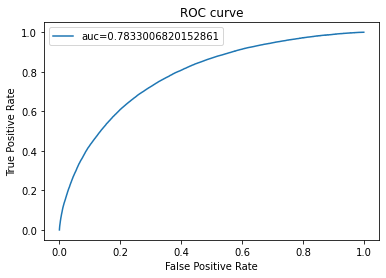

In [127]:
fpr, tpr, thresh= roc_curve(train_df['TARGET'], oof_pred)
auc = roc_auc_score(train_df['TARGET'], oof_pred)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=0)

### 清理无用特征

In [166]:
#查看5个fold的特征重要性表格
df_feature_importance_avg=df_feature_importance.groupby('feature').mean().sort_values(by="importance", ascending=False)
df_feature_importance_avg.columns=pd.Index(['importance'])
df_feature_importance_avg.reset_index(level=0, inplace = True)
df_feature_importance_avg.head()

,feature,importance
0,EXT_SOURCE_1,154.2
1,PAYMENT_RATE,145.4
2,EXT_SOURCE_2,119.8
3,EXT_SOURCE_3,104.6
4,DAYS_BIRTH,89.6


In [164]:
#查看最有用的25个特征
df_best25 = df_feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:25]
df_best25
#df_best25.to_csv('best25_features.csv')

,importance
feature,
EXT_SOURCE_1,154.2
PAYMENT_RATE,145.4
EXT_SOURCE_2,119.8
EXT_SOURCE_3,104.6
DAYS_BIRTH,89.6
CNT_INSTALMENT_FUTURE_mean,66.8
AMT_ANNUITY,61.6
DAY_PAST_DUE_mean,58.8
DAYS_EMPLOYED,57.4


In [167]:
#查看有多少没有贡献的特征：211个
zero_features = list(df_feature_importance_avg[df_feature_importance_avg['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))

There are 211 features with 0.0 importance


In [170]:
#去掉这211个特征后重新训练看看效果
clc_train_df = train_df.drop(columns=zero_features)
clc_test_df = test_df.drop(columns=zero_features)
print('After clean, train dataset shape is: {}, test dataset shape is: {}'.format(clc_train_df.shape, clc_test_df.shape))


####################################################################重新训练##############################
####################加大了树n_estimators，降低学习率，并且加大early_stopping_rounds#######################
num_folds=5
folds = KFold(n_splits=num_folds,shuffle=True,random_state=72)

oof_pred = np.zeros(clc_train_df.shape[0])
test_pred = np.zeros(clc_test_df.shape[0])

#feature_importance = pd.DataFrame()
feat = [fea for fea in clc_train_df.columns if fea not in ['SK_ID_CURR','SK_ID_PREV','SK_ID_BUREAU', 'index', 'TARGET']]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(clc_train_df[feat], clc_train_df['TARGET'])):
    #training data for folds
    train_x, train_y = clc_train_df[feat].iloc[train_idx], clc_train_df['TARGET'].iloc[train_idx]
    #test data for folds
    valid_x, valid_y = clc_train_df[feat].iloc[valid_idx], clc_train_df['TARGET'].iloc[valid_idx]
    
    #create the model
    model = LGBMClassifier(n_estimators=1000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 72)
    
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 300)
    
    oof_pred[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:,1]
    test_pred += model.predict_proba(clc_test_df[feat],num_iteration=model.best_iteration_)[:,1]/folds.n_splits
    
    print('Fold %2d AUC : %.6f' % (n_fold+1, roc_auc_score(valid_y, oof_pred[valid_idx])))
    
print('Full AUC: %.6f' % roc_auc_score(clc_train_df['TARGET'], oof_pred))

clc_test_df['TARGET'] = test_pred
clc_test_df[['SK_ID_CURR','TARGET']].to_csv('submission_file.csv', index=False)

After clean, train dataset shape is: (307511, 392), test dataset shape is: (48744, 392)
Training until validation scores don't improve for 300 rounds
[100]	training's auc: 0.802911	training's binary_logloss: 0.548173	valid_1's auc: 0.778423	valid_1's binary_logloss: 0.558661
[200]	training's auc: 0.8294	training's binary_logloss: 0.516114	valid_1's auc: 0.785795	valid_1's binary_logloss: 0.536276
[300]	training's auc: 0.848151	training's binary_logloss: 0.495199	valid_1's auc: 0.787206	valid_1's binary_logloss: 0.52325
[400]	training's auc: 0.864169	training's binary_logloss: 0.477162	valid_1's auc: 0.787399	valid_1's binary_logloss: 0.511848
[500]	training's auc: 0.878065	training's binary_logloss: 0.460891	valid_1's auc: 0.786622	valid_1's binary_logloss: 0.501681
[600]	training's auc: 0.890485	training's binary_logloss: 0.445672	valid_1's auc: 0.786075	valid_1's binary_logloss: 0.492007
Early stopping, best iteration is:
[383]	training's auc: 0.861664	training's binary_logloss: 0.48

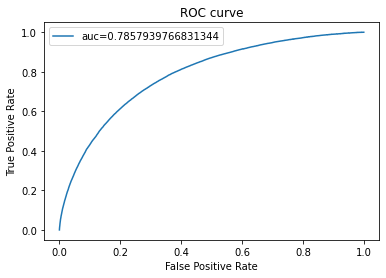

In [171]:
fpr, tpr, thresh= roc_curve(clc_train_df['TARGET'], oof_pred)
auc = roc_auc_score(clc_train_df['TARGET'], oof_pred)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=0)